# MoRu Phase Prediction using GPyTorch Gaussian Process Classifier

In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

# %matplotlib inline
# %load_ext autoreload
# %autoreload 2

/Users/bajpp/miniforge/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate Dataset from JSON Dump

The dataset $\mathcal{D} \subset \mathbb{R}_{\ge 0}^{n_\text{samples} \times (n_\text{elements} + n_\text{phases} + 2)}$ is defined as:
$$\mathcal{D} = \{\mathbf{x}_i \, | \, i \in \{1, \dots, n_\text{samples}\}\}$$
where, $\mathbf{x}_i$ is a single sample such that:
$$\mathbf{x}_i = \left\{{T, P, \{c_j \, | \, j \in \mathcal{1, \dots, n_\text{elements}}\}, \{n_\phi \, | \, \phi \in \mathcal{1, \dots, n_\text{phases}}\}}\right\}$$
where, $c_j$ denotes number of moles of element $j$ and $n_\phi$ denotes the number of moles of phase $\phi$.

In [2]:
import json

filename = '../data/MoRu_sparse.json'
stream = open(filename)
data = json.load(stream)
stream.close()


In [3]:
n_data = len(data)
n_elements = len(data['2']['elements'])
n_phases = len(data['2']['solution phases']) + len(data['2']['pure condensed phases'])

dataset = np.zeros((n_data, 2 * n_elements + n_phases + 2))

phase_names = list(data['2']['solution phases'].keys())
phase_names += list(data['2']['pure condensed phases'].keys())
element_names = list(data['2']['elements'].keys())

In [4]:
keys = list(data.keys())
for i in keys:
    dataset[keys.index(i), 0] = data[i]["temperature"]
    dataset[keys.index(i), 1] = data[i]["pressure"]

    for j in range(n_elements):
        if not (data[i]['elements'].get(element_names[j]) is None):
            dataset[keys.index(i), 2 + j] = data[i]["elements"][element_names[j]]["moles"]
            dataset[keys.index(i), 2 + n_elements + j] = data[i]["elements"][element_names[j]]["element potential"]
        else:
            dataset[keys.index(i), 2 + j] = 0.0
            dataset[keys.index(i), 2 + n_elements + j] = 0.0


    for j in range(n_phases):
        if not (data[i]['solution phases'].get(phase_names[j]) is None):
            dataset[keys.index(i), 2 + 2 * n_elements + j] = data[i]["solution phases"][phase_names[j]]["moles"]
        elif not (data[i]['pure condensed phases'].get(phase_names[j]) is None):
            dataset[keys.index(i), 2 + 2 * n_elements + j] = data[i]["pure condensed phases"][phase_names[j]]["moles"]
        else:
            dataset[keys.index(i), 2 + 2 * n_elements + j]


In [5]:
dataset = dataset[dataset[:,2] != 0]
dataset = dataset[dataset[:,3] != 0]
n_data = len(dataset)

### Generate Training Data

- Training samples $n_\text{Train} = 0.6 * n_\text{Total}$
- Input $\mathbf{X} = {T, P, \mathbf{c}}$
- Output $\mathbf{y} = {\mathbf{n}_\phi}$

In [32]:
n_training = int(n_data * 0.4)

choice = np.random.choice(range(dataset.shape[0]), size=(n_training,), replace=False)
train_indices = np.zeros(dataset.shape[0], dtype=bool)
train_indices[choice] = True
test_indices = ~train_indices

train = dataset[train_indices]
test = dataset[test_indices]

X_train = train[:,0:(2 + n_elements)]

# # Change the outputs to 0.0 / 1.0 based on the number of moles of phase
# y_train = (train[:,(2 + n_elements):] > 0.0).astype(float)

# Use the original moles
mu_train = train[:,(2 + n_elements):(2 + 2 * n_elements)]
moles_train = train[:,(2 + 2 * n_elements):]
print(moles_train.shape)

(720, 10)


In [33]:
# Convert to Torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_train_unscaled = X_train.detach().clone()
mu_train = torch.tensor(mu_train, dtype=torch.float32)
mu_train_unscaled = mu_train.detach().clone()
moles_train = torch.tensor(moles_train, dtype=torch.float32)
moles_train_unscaled = moles_train.detach().clone()

In [34]:
# Calculate mean and standard deviation of inputs
X_mean = X_train.mean(0,keepdim=True)
X_std = X_train.std(0,keepdim=True)

# Standard deviation of pressure is equal to 0.0. Change this to 1.0 to avoid division by zero when scaling
X_std[X_std == 0] = 1.0

# Scale inputs to mean 0 and standard deviation 1 for better convergence
X_train = (X_train - X_mean) / X_std

# Calculate mean and standard deviation of outputs
mu_mean = mu_train.mean(0,keepdim=True)
mu_std = mu_train.std(0,keepdim=True)

# Scale inputs to mean 0 and standard deviation 1 for better convergence
mu_train = (mu_train - mu_mean) / mu_std

# Calculate mean and standard deviation of outputs
moles_mean = moles_train.mean(0,keepdim=True)
moles_std = moles_train.std(0,keepdim=True)

# Scale inputs to mean 0 and standard deviation 1 for better convergence
moles_train = (moles_train - moles_mean) / moles_std

### Test Data

In [35]:
# Scale test input values to mean 0 and standard deviation 1 based on values from before
X_test_unscaled = torch.tensor(test[:,0:(2 + n_elements)], dtype=torch.float32)
X_test = (X_test_unscaled - X_mean) / X_std

# 0 / 1 Output case
# moles_test = (test[:,(2 + 2 * n_elements):] > 0.0).astype(float)

# Original moles of phase
moles_test = test[:,(2 + 2 * n_elements):]
moles_test = torch.tensor(moles_test, dtype=torch.float32)

mu_test = test[:,(2 + n_elements):(2 + 2 * n_elements)]
mu_test = torch.tensor(mu_test, dtype=torch.float32)


# Combined test and training data
X_all_unscaled = torch.cat([X_train_unscaled, X_test_unscaled])
X_all = torch.cat([X_train, X_test])
mu_all = torch.cat([mu_train, mu_test])
moles_all = torch.cat([moles_train, moles_test])

In [36]:
print(X_train.shape, X_test.shape)
print(mu_train.shape, mu_test.shape)
print(moles_train.shape, moles_test.shape)

torch.Size([720, 4]) torch.Size([1080, 4])
torch.Size([720, 2]) torch.Size([1080, 2])
torch.Size([720, 10]) torch.Size([1080, 10])


### Input Space Mapping

/var/folders/wc/8ppk7xj10vbc_xtfrp0k7bnnjj2tt8/T/ipykernel_86134/3104627853.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


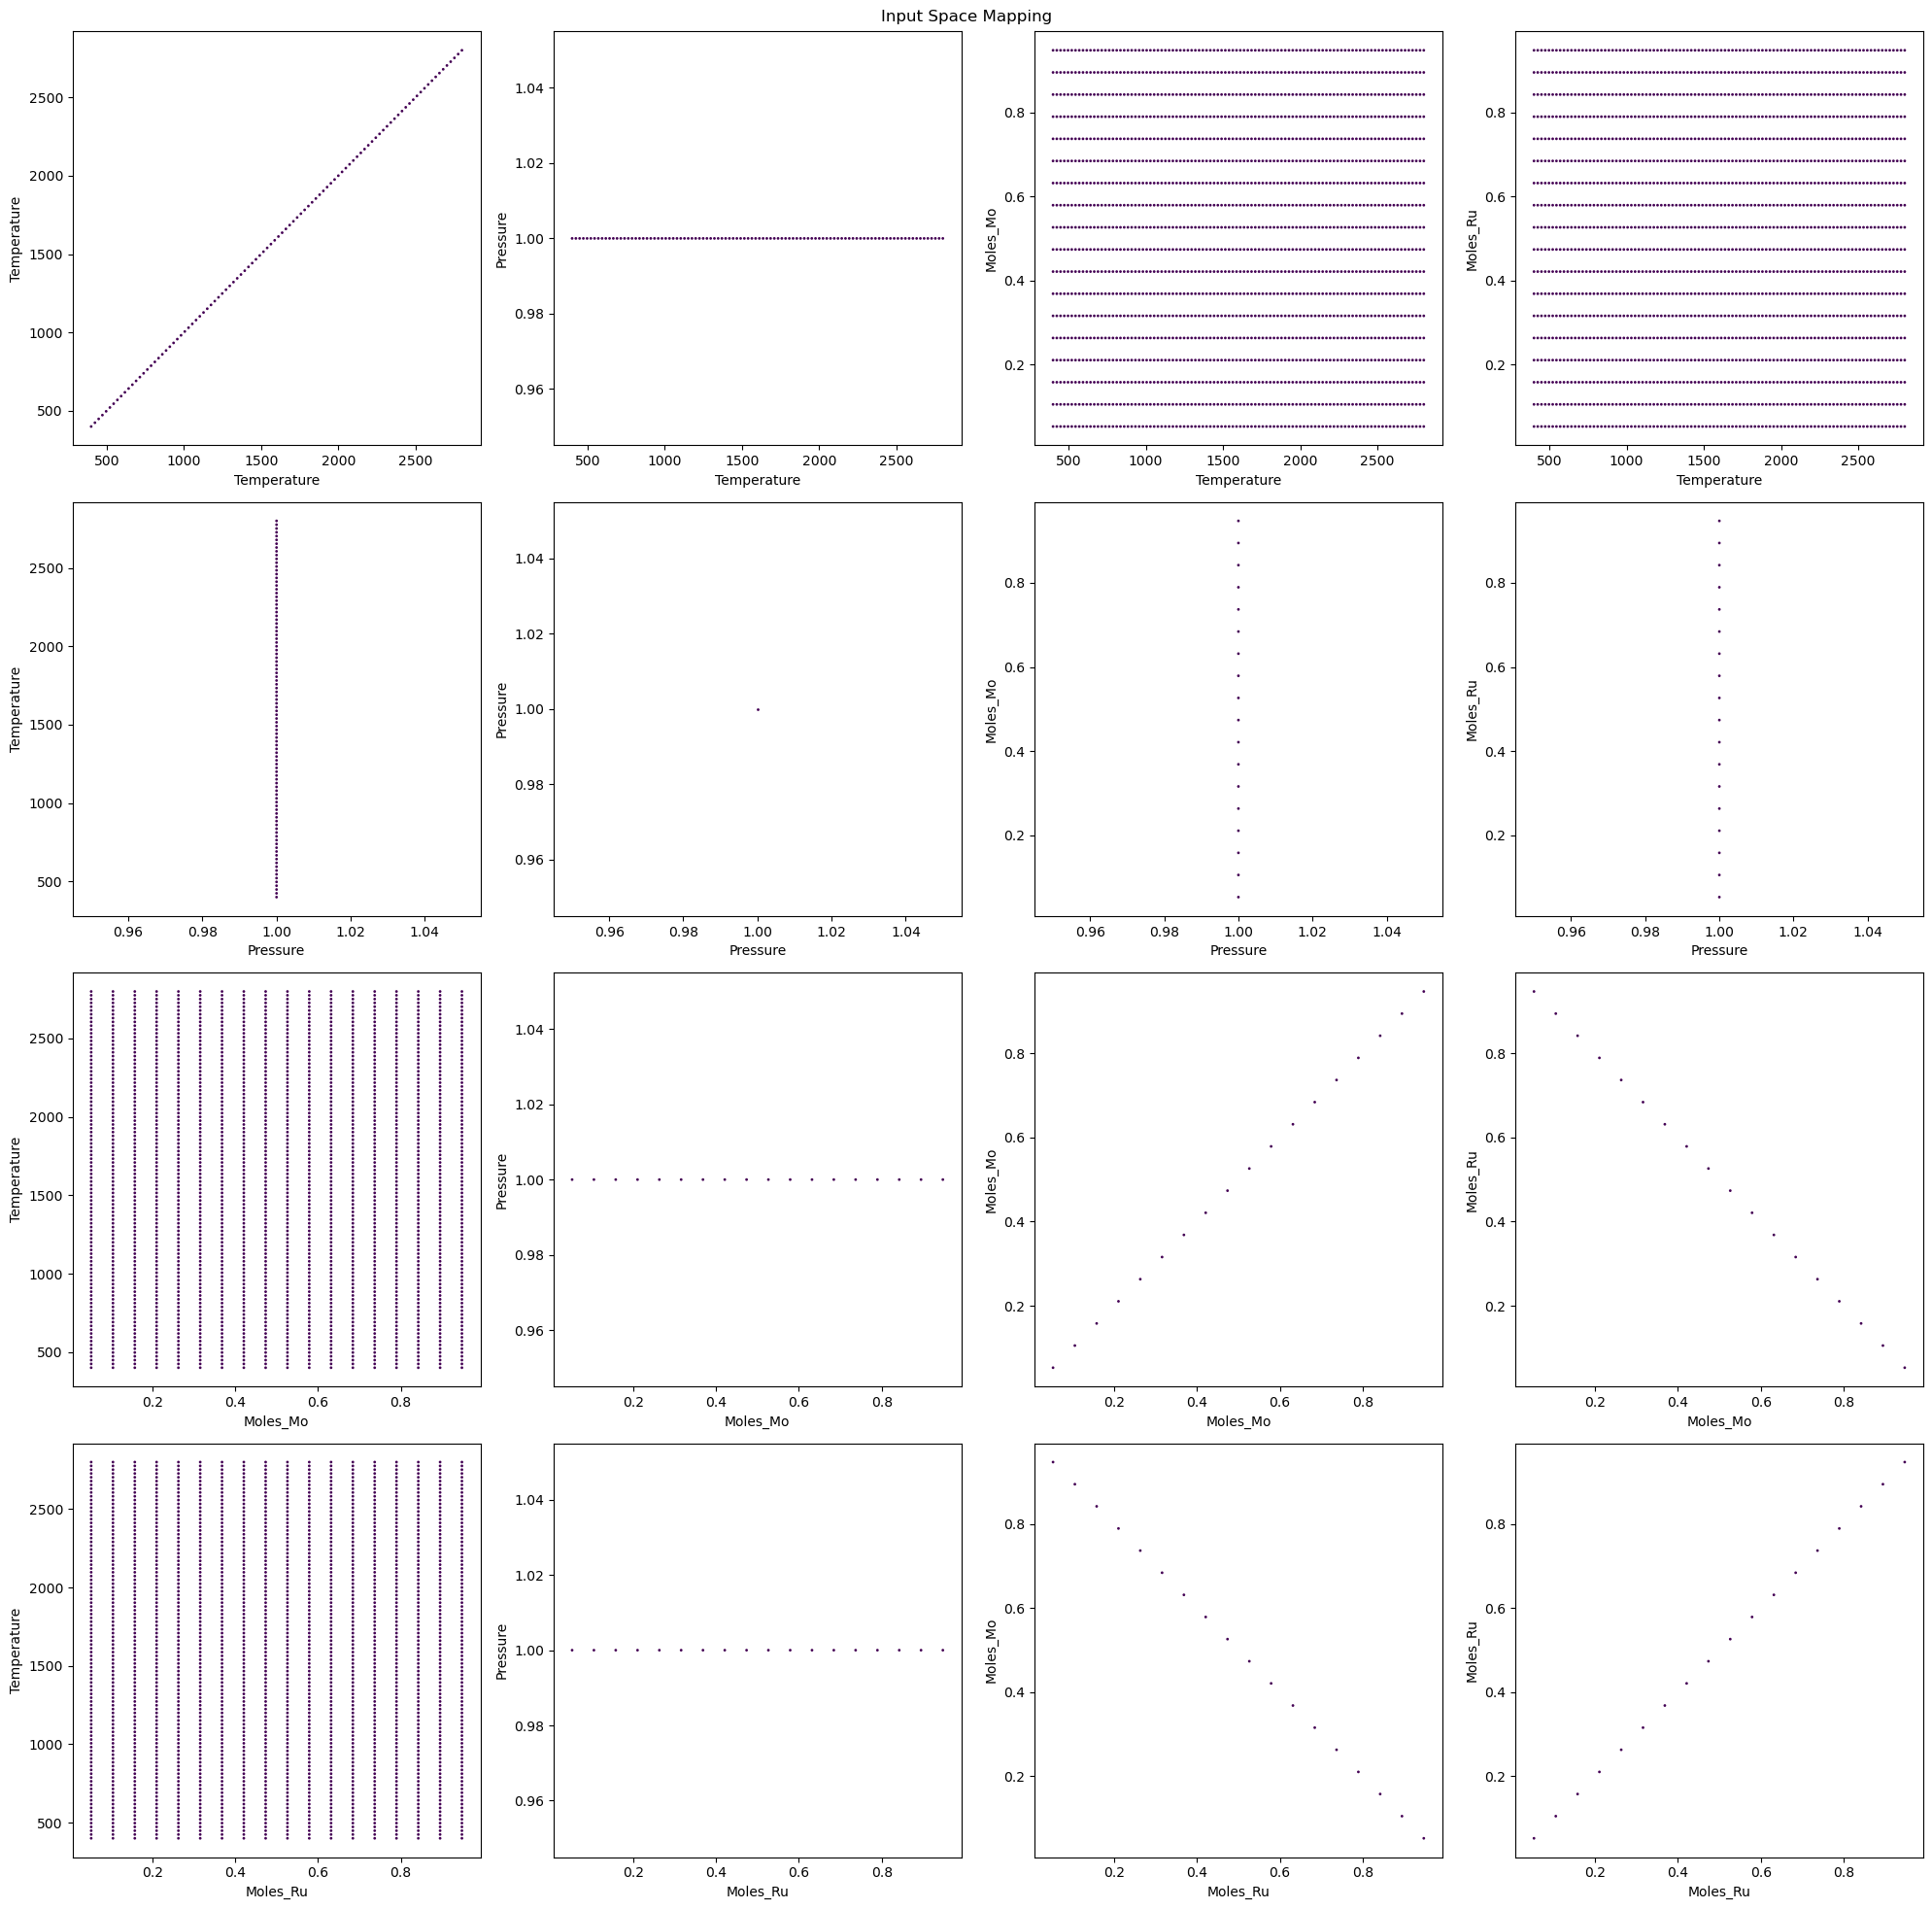

In [37]:
labels = ['Temperature', 'Pressure', 'Moles_Mo', 'Moles_Ru']
n_columns = len(labels)

fig, ax = plt.subplots(nrows=n_columns, ncols=n_columns, figsize=(20, 20))

for i in range(n_columns):
  for j in range(n_columns):
    reduced, counts = np.unique(np.transpose(np.array([X_all_unscaled[:,i], X_all_unscaled[:,j]])), axis=0, return_counts=True)
    rx, ry = np.transpose(reduced)

    ax[i][j].scatter(rx, ry, c=counts, s=1)
    ax[i][j].set_xlabel(labels[i])
    ax[i][j].set_ylabel(labels[j])

fig.suptitle('Input Space Mapping\n')
fig.tight_layout()
fig.show()

### Multitask

In [38]:
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(X_train, mu_train, likelihood)

In [40]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 250


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, mu_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/250 - Loss: 0.732
Iter 2/250 - Loss: 0.688
Iter 3/250 - Loss: 0.643
Iter 4/250 - Loss: 0.598
Iter 5/250 - Loss: 0.552
Iter 6/250 - Loss: 0.507
Iter 7/250 - Loss: 0.461
Iter 8/250 - Loss: 0.414
Iter 9/250 - Loss: 0.368
Iter 10/250 - Loss: 0.321
Iter 11/250 - Loss: 0.274
Iter 12/250 - Loss: 0.227
Iter 13/250 - Loss: 0.180
Iter 14/250 - Loss: 0.132
Iter 15/250 - Loss: 0.085
Iter 16/250 - Loss: 0.038
Iter 17/250 - Loss: -0.010
Iter 18/250 - Loss: -0.058
Iter 19/250 - Loss: -0.106
Iter 20/250 - Loss: -0.154
Iter 21/250 - Loss: -0.202
Iter 22/250 - Loss: -0.250
Iter 23/250 - Loss: -0.298
Iter 24/250 - Loss: -0.346
Iter 25/250 - Loss: -0.394
Iter 26/250 - Loss: -0.443
Iter 27/250 - Loss: -0.491
Iter 28/250 - Loss: -0.540
Iter 29/250 - Loss: -0.588
Iter 30/250 - Loss: -0.636
Iter 31/250 - Loss: -0.685
Iter 32/250 - Loss: -0.733
Iter 33/250 - Loss: -0.781
Iter 34/250 - Loss: -0.829
Iter 35/250 - Loss: -0.876
Iter 36/250 - Loss: -0.924
Iter 37/250 - Loss: -0.971
Iter 38/250 - Loss: -1.018

In [14]:
# def filter_func(A, B):
#   if(A.shape[0] != B.shape[0]):
#     print("Shapes not same")
#   else:
#     comb = np.array(A.shape[0])
#     print(comb.shape)
#     for i in np.arange(A.shape[0]):
#       if (A[i] == True and B[i] == True):
#         comb[i] = True
#       else:
#         comb[i] = False
#     return comb

In [41]:
# filter_Mo_train = X_train_unscaled[:,2] != 0.00
# filter_Ru_train = X_train_unscaled[:,3] != 0.00
# filter_temp_train = X_train_unscaled[:,0] == 1200.00
# filter_Mo_test = X_test_unscaled[:,2] != 0.00
# filter_Ru_test = X_test_unscaled[:,3] != 0.00
# filter_temp_test = X_test_unscaled[:,0] == 1200.00
# filter_Mo_all = X_all_unscaled[:,2] != 0.00
# filter_Ru_all = X_all_unscaled[:,3] != 0.00
# filter_temp_all = X_all_unscaled[:,0] == 1200.00
# test_filter = filter_func(filter_Mo_train.flatten(), filter_temp_train.flatten())

filter_train = X_train_unscaled[:,0] == 1200.00
filter_test = X_test_unscaled[:,0] == 1200.00
filter_all = X_all_unscaled[:,0] == 1200.00

Text(0.5, 1.0, 'Molybdenum Chemical Potential')

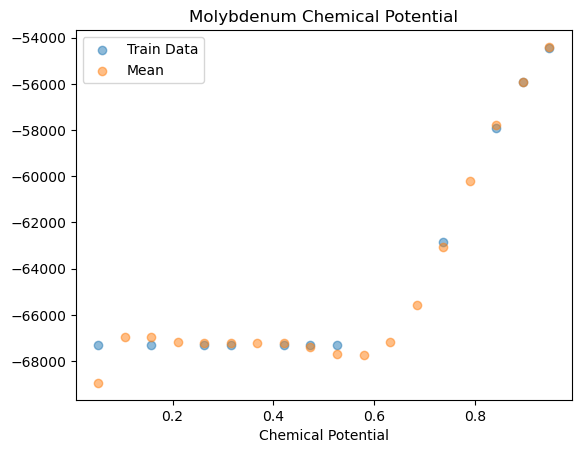

In [45]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
# f, (y1_ax, y2_ax) = plt.subplots(1, 1)

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions_test = likelihood(model(X_test))
    mean_test = predictions_test.mean
    lower_test, upper_test = predictions_test.confidence_region()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions_all = likelihood(model(X_all))
    mean_all = predictions_all.mean
    lower_all, upper_all = predictions_all.confidence_region()

# print(lower_all.shape, upper_all.shape)

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task


# Plot training data as black stars
plt.scatter((X_train[filter_train,2].detach().numpy()) * X_std[0,2].item() + X_mean[0,2].item(), (mu_train[filter_train, 0].detach().numpy()) * mu_std[0,0].item() + mu_mean[0,0].item(), alpha=0.5)
# y1_ax.scatter((X_train[filter_train,2].detach().numpy()), (mu_train[filter_train, 0].detach().numpy()))
# Predictive mean as blue line
plt.scatter((X_all[filter_all,2].detach().numpy()) * X_std[0,2].item() + X_mean[0,2].item(), (mean_all[filter_all, 0].detach().numpy()) * mu_std[0,0].item() + mu_mean[0,0].item(), alpha=0.5)
# y1_ax.scatter((X_test[filter_test,2].detach().numpy()), (mean_test[filter_test, 0].detach().numpy()))
# Shade in confidence
# y1_ax.fill_between(X_all[:,2].numpy(), lower_all[:, 0].numpy(), upper_all[:, 0].numpy(), alpha=0.5)
plt.xlabel('Mole Fraction Mo')
plt.xlabel('Chemical Potential')
plt.legend(['Train Data', 'Mean'])
plt.title(r'Molybdenum Chemical Potential')

# y1_ax.scatter((X_train[filter_train,3].detach().numpy()) * X_std[0,3].item() + X_mean[0,3].item(), (mu_train[filter_train, 1].detach().numpy()) * mu_std[0,1].item() + mu_mean[0,1].item(), alpha=0.5)
# # y1_ax.scatter((X_train[filter_train,2].detach().numpy()), (mu_train[filter_train, 0].detach().numpy()))
# # Predictive mean as blue line
# y1_ax.scatter((X_all[filter_all,3].detach().numpy()) * X_std[0,3].item() + X_mean[0,3].item(), (mean_all[filter_all, 1].detach().numpy()) * mu_std[0,1].item() + mu_mean[0,1].item(), alpha=0.5)
# # y1_ax.scatter((X_test[filter_test,2].detach().numpy()), (mean_test[filter_test, 0].detach().numpy()))
# # Shade in confidence
# # y1_ax.fill_between(X_all[:,2].numpy(), lower_all[:, 0].numpy(), upper_all[:, 0].numpy(), alpha=0.5)
# y1_ax.set_x([-3, 3])
# y1_ax.legend(['Observed Data', 'Mean'])
# y1_ax.set_title(r'Molybdenum Chemical Potential')

# None

### Variational (Non-Gaussian Likelihood) Classification

In [46]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy
# from gpytorch.variational import VariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(X_train.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, X_train, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
# model = GPClassificationModel(X_train)
model = GPClassificationModel(X_train)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [51]:
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 5000

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, moles_train.numel())


for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(X_train)
    # Calc loss and backprop gradients
    loss = -mll(output, mu_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

<bound method TorchDistributionMixin.shape of MultivariateNormal(loc: torch.Size([720]))>
torch.Size([720, 2])


RuntimeError: The size of tensor a (720) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(400, 2800, 101)
    test_x = (test_x - test_x.mean(0)) / test_x.std(0)
    # Get classification predictions
    test_y = model(test_x)
    observed_pred = likelihood(test_y)
    upper, lower = test_y.confidence_region()

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
    pred_labels = observed_pred.mean.ge(0.5).float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-0.1, 1.1])
    ax.legend(['Observed Data', 'Mean'])

### Exact GP Regression on Classification Label

### Regression

In [ ]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module =  gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [ ]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 5000

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

loss_ml = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -loss_ml(output, train_y)
    loss.backward()
    print(f'Iteration: {i + 1}/{training_iter} \t Loss: {loss.item():.3f} \t Lengthscale: {model.covar_module.base_kernel.lengthscale.item():.3f} \t Noise:{model.likelihood.noise.item():.3f}')
    optimizer.step()

In [ ]:
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(400, 2800, 101)
    test_x = (test_x - test_x.mean(0)) / test_x.std(0)
    observed_prediction = likelihood(model(test_x))

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1)

    # Get upper and lower confidence bounds
    lower, upper = observed_prediction.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_prediction.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    # ax.set_ylim([-0.5, 2])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
